In [2]:
%pprint

Pretty printing has been turned OFF


In [38]:
import json
import matplotlib.pyplot as plt
import nltk
import re

from pyspark.ml.clustering import LDA
from pyspark.ml.feature import CountVectorizer, StopWordsRemover, Tokenizer
from pyspark.sql.functions import array, col, concat_ws, count, countDistinct, explode, from_json, lower, size, split, to_date, udf, from_unixtime, to_timestamp
from pyspark.sql.types import StringType, ArrayType, DateType, StructField, StructType
from unicodedata import normalize
from wordcloud import WordCloud

In [4]:
# Download portuguese stopwords
stopwords = nltk.corpus.stopwords.words('portuguese')

### Helping UDFs.

In [5]:
def clean_text(text:str) -> str:
    """
    Removes special characters and set to lower case.
    """
    text = normalize('NFKD', text).encode('ASCII','ignore').decode('ASCII').lower()
    # Get only numbers and letters
    text = re.sub(r'[^A-Za-z0-9 ]', '', text)
    # Remove multiple spaces
    text = re.sub(' +', ' ', text)
    return text

udf_clean_text = udf(lambda x:clean_text(x), StringType())

In [6]:
# Remove special characters
stopwords = [clean_text(word) for word in stopwords]
# Remove list duplicates
stopwords = list(set(stopwords))

### Get raw data

In [7]:
df_raw = spark.read.json('/datasets/homofobia/facebook_homofobia_01_2M.json')

2022-02-21 20:11:00,127 WARN util.Utils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.debug.maxToStringFields' in SparkEnv.conf.


### Remove rows with blank messages

In [8]:
df_raw = df_raw.filter('message IS NOT NULL')

### Get necessary columns

In [9]:
df_raw = df_raw.select('id', 'created_time', 'from', 'is_hidden', 'message', 'place.name', 'place.location', 'shares')

### Add new columns

Create column with clean text

In [10]:
df_clean = df_raw.withColumn('message_clean', udf_clean_text(col('message')))

Create columns with tokens and removed stopwords 

In [11]:
# Extend regular english list with portuguese words
stopwords.extend(StopWordsRemover().getStopWords())
# A few words found previously on tests
stopwords.extend(['q', 'eh', 'vc', 'ai', 'pra', 'ser', 'y', '666', '3'])

# Create a column of tokens
tokenizer = Tokenizer(inputCol="message_clean", outputCol="word_list")
df_clean = tokenizer.transform(df_clean)

# Remove stopwords
remover = StopWordsRemover(inputCol="word_list", outputCol="no_stopwords", stopWords=stopwords)
df_clean = remover.transform(df_clean)

Add location columns

In [12]:
df_clean = df_clean.withColumnRenamed('name', 'place_name')

# Set schema to convert location column as StructField
location_schema = StructType([StructField("latitude", StringType(), True),
                    StructField("longitude", StringType(), True),
                    StructField("country", StringType(), True),
                    StructField("city", StringType(), True)],
                    )

df_clean = df_clean.withColumn("location", from_json(col("location"), location_schema))


Add string column without stopwords

In [13]:
df_clean = df_clean.withColumn('no_stopwords_string', concat_ws(' ', 'no_stopwords'))

Replace shares column with bigint type

In [14]:
df_clean = df_clean.withColumn("shares", col("shares.count"))

### Generating a Wordcloud

In [15]:
all_words = ' '.join(row.no_stopwords_string for row in df_clean.select('no_stopwords_string').collect())

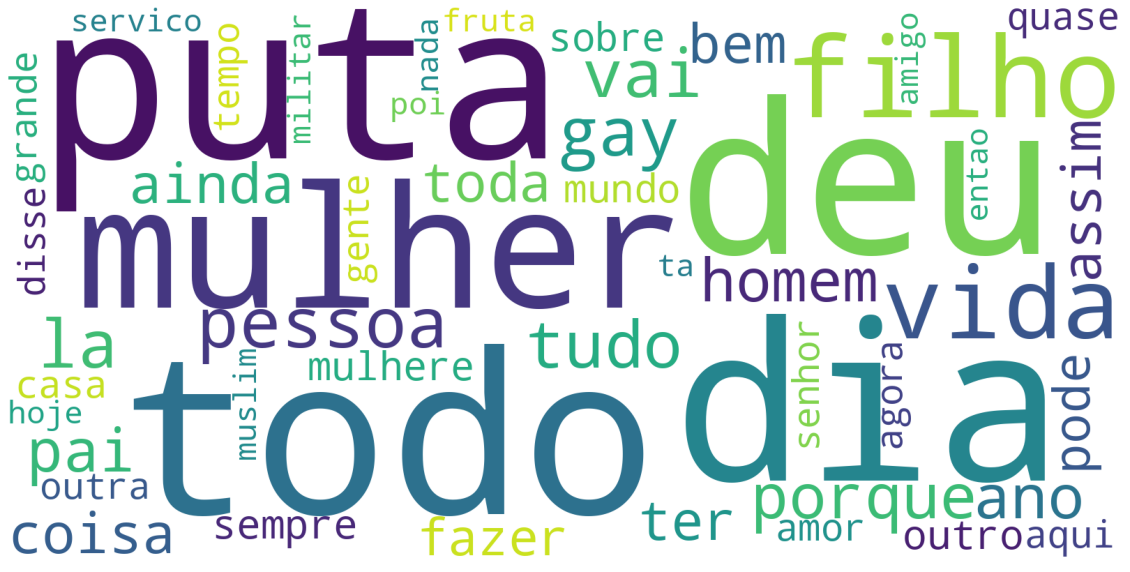

In [16]:
wordcloud = WordCloud(background_color="white",
                      max_words=50,
                      collocations=False,
                      width=1600, 
                      height=800).generate(all_words)

fig, ax = plt.subplots(figsize=(20,12))
ax.imshow(wordcloud, interpolation='bilinear')
ax.set_axis_off()
 
plt.imshow(wordcloud);

### Get top five message creator profiles

In [17]:
popular_creator = df_clean.groupBy('from.id', 'from.name').agg(countDistinct('id'))

Set column names

In [18]:
popular_creator = popular_creator.withColumnRenamed('id', 'Profile')
popular_creator = popular_creator.withColumnRenamed('name', 'Name')
popular_creator = popular_creator.withColumnRenamed('count(DISTINCT id)', 'Messages')

In [19]:
popular_creator = popular_creator.orderBy(col("Messages").desc()).limit(5).toPandas()

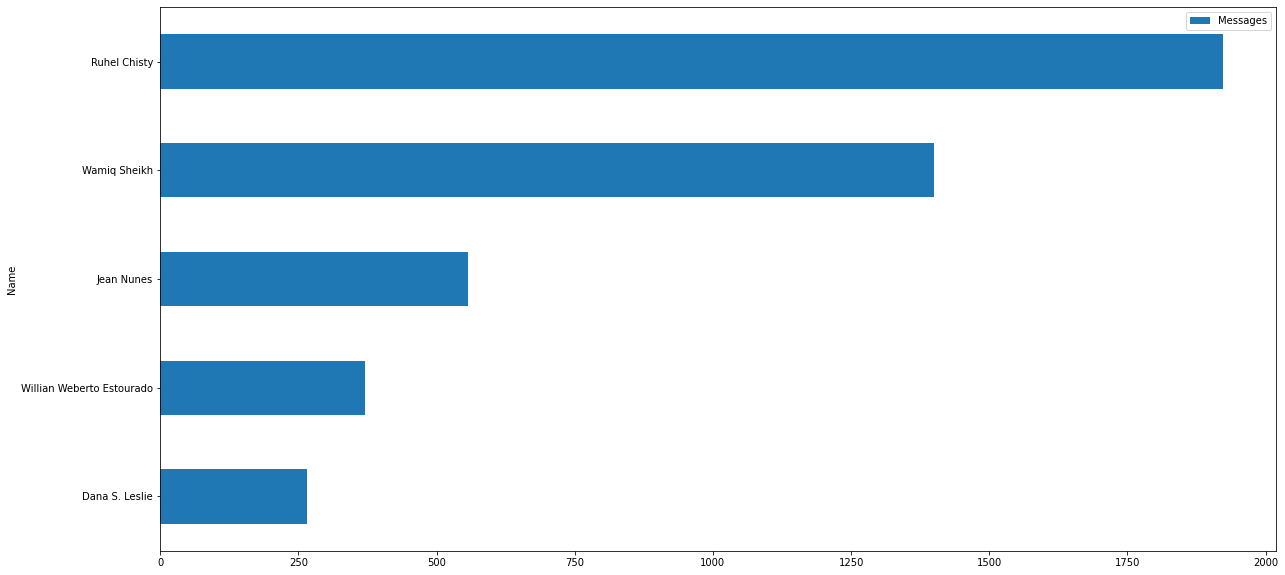

In [20]:
popular_creator = popular_creator.sort_values('Messages', ascending=True) \
                        .plot.barh(x='Name', y='Messages', rot=0, figsize=(20, 10), fontsize=10)

### Get top five popular profiles

In [21]:
popular_profiles = df_clean.filter('shares IS NOT NULL').groupBy('from.id', 'from.name').sum('shares')

Set column names

In [22]:
popular_profiles = popular_profiles.withColumnRenamed('id', 'Profile')
popular_profiles = popular_profiles.withColumnRenamed('name', 'Name')
popular_profiles = popular_profiles.withColumnRenamed('sum(shares)', 'Shares')

In [23]:
popular_profiles = popular_profiles.orderBy(col("shares").desc()).limit(5).toPandas()

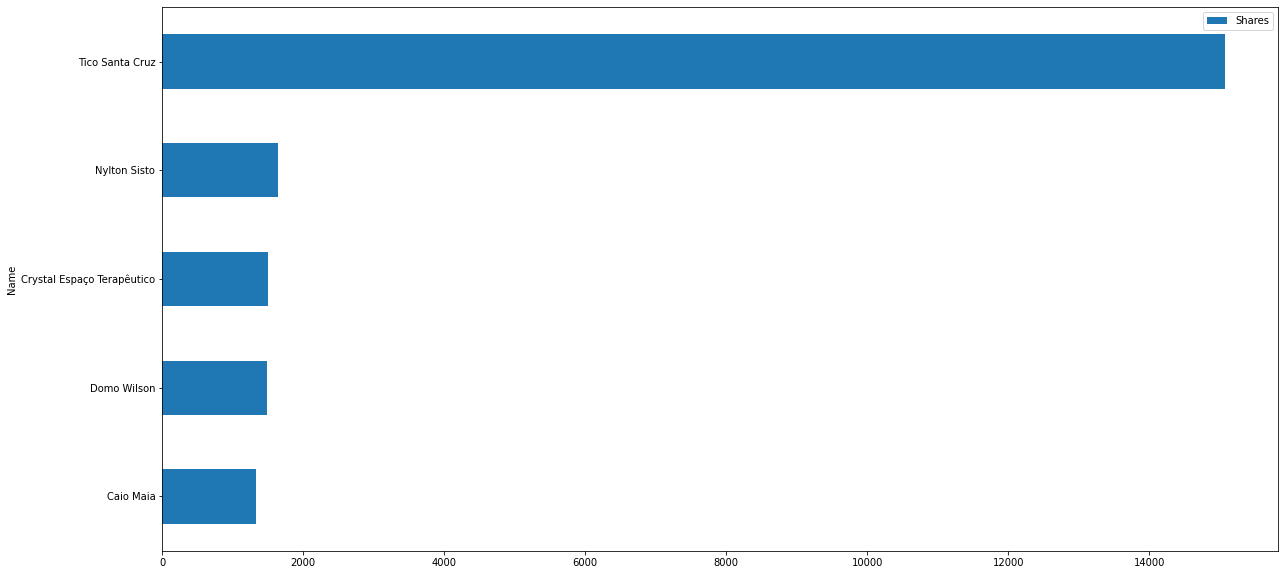

In [24]:
popular_profiles = popular_profiles.sort_values('Shares', ascending=True) \
                        .plot.barh(x='Name', y='Shares', rot=0, figsize=(20, 10), fontsize=10)

### Get top ten publishing brazilian cities

In [25]:
popular_cities = df_clean.filter('location.city IS NOT NULL AND location.country = "Brazil"') \
                    .groupBy('location.city').agg(countDistinct('id'))

In [26]:
popular_cities = popular_cities.withColumnRenamed('city', 'City')
popular_cities = popular_cities.withColumnRenamed('count(DISTINCT id)', 'Messages')

In [27]:
popular_cities = popular_cities.orderBy(col("Messages").desc()).limit(10).toPandas()

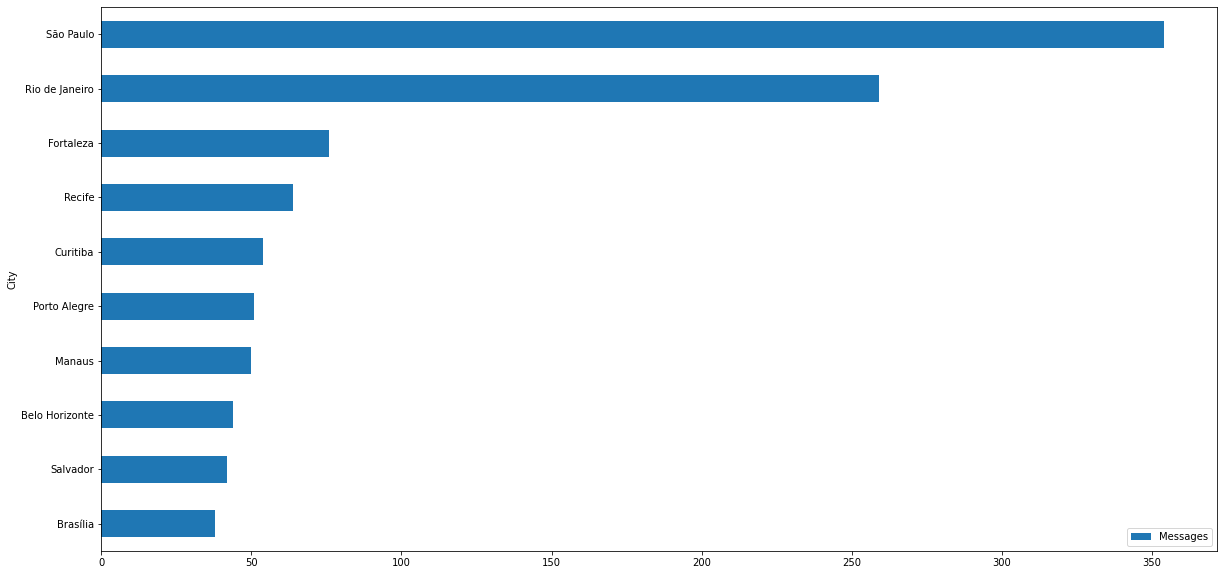

In [28]:
popular_cities = popular_cities.sort_values('Messages', ascending=True) \
                    .plot.barh(x='City', y='Messages', rot=0, figsize=(20, 10), fontsize=10)

### Simple check on words count

In [29]:
token_counts = df_clean.select("id", explode("no_stopwords").alias("token"))\
    .groupBy("token").count()\
    .orderBy(col("count").desc())

In [30]:
token_counts.show(100)

[Stage 11:==========================================>           (159 + 4) / 200]

+---------+------+
|    token| count|
+---------+------+
|     puta|143277|
|   mulher|135093|
|      dia|118091|
|     deus|115705|
|     vida|108675|
|      vai| 99517|
|     tudo| 96136|
|   porque| 89867|
|    todos| 88838|
|       la| 88224|
|      gay| 85025|
|    homem| 81298|
|    ainda| 72578|
|  pessoas| 70673|
|      bem| 70434|
|    assim| 69360|
|      ter| 68578|
|     todo| 68160|
|    fazer| 67869|
|    filho| 67253|
|     pode| 67061|
|   sempre| 66692|
|     anos| 63717|
| mulheres| 63221|
|    mundo| 61859|
|    sobre| 61838|
|     amor| 58625|
|    quase| 58093|
|     aqui| 57777|
|     casa| 57418|
|    disse| 55344|
|    gente| 54605|
|    agora| 54310|
|   senhor| 54216|
|        1| 52443|
|     nada| 51763|
|     hoje| 51257|
|    entao| 51214|
|  militar| 50180|
|     pois| 49974|
|  servico| 49359|
|       ta| 49012|
|    nunca| 48697|
|        c| 48208|
|    tempo| 48203|
|   filhos| 48091|
|  muslims| 47949|
|      bom| 47572|
|   grande| 45810|
|     cada| 

### Generate features from textual data

In [31]:
# from pyspark.ml.feature import CountVectorizer


cv = CountVectorizer(inputCol="no_stopwords", outputCol="features", vocabSize=500, minDF=3.0)

# Train the model
cv_model = cv.fit(df_clean)
# Transform the data. Output column name will be features.
vectorized_tokens = cv_model.transform(df_clean)

### Build the LDA Model

In [32]:
# from pyspark.ml.clustering import LDA


num_topics = 4

lda = LDA(k=num_topics, maxIter=10)
model = lda.fit(vectorized_tokens)
ll = model.logLikelihood(vectorized_tokens)
lp = model.logPerplexity(vectorized_tokens)

print(f"The lower bound on the log likelihood of the entire corpus: {str(ll)}")
print(f"The upper bound on perplexity: {str(lp)}")

[Stage 50:======================================================> (52 + 1) / 53]

The lower bound on the log likelihood of the entire corpus: -65346983.20572528
The upper bound on perplexity: 5.645012706030904


### Print topics

In [33]:
# Extract vocabulary from CountVectorizer
vocab = cv_model.vocabulary
topics = model.describeTopics()   
topics_rdd = topics.rdd

topics_words = topics_rdd\
       .map(lambda row: row['termIndices'])\
       .map(lambda idx_list: [vocab[idx] for idx in idx_list])\
       .collect()

for idx, topic in enumerate(topics_words):
    print("topic: {}".format(idx))
    print("*"*25)
    for word in topic:
       print(word)
    print("*"*25)

topic: 0
*************************
deus
militar
servico
c
delegacia
mulher
homem
senhor
1
disse
*************************
topic: 1
*************************
dia
mulher
vai
tudo
vida
la
todos
porque
bem
pessoas
*************************
topic: 2
*************************
gay
viado
yo
boneca

muslims
crimes
way
sunnah
bipolar
*************************
topic: 3
*************************
puta
hindu
india
muslims
people
indian
house
army
male
like
*************************


In [54]:
#df_clean.withColumn('date_again', to_timestamp(from_unixtime('created_time.$date', 'yyyy-MM-dd HH:mm:ss'))).show()
df_clean.select(from_unixtime('created_time.$date', 'yyyy-MM-dd HH:mm:ss').alias('ts')).show(10)

+--------------------+
|                  ts|
+--------------------+
|46211-09-07 17:00:00|
|46335-06-25 21:03:20|
|46207-02-18 10:00:00|
|46336-08-10 12:30:00|
|46221-05-17 02:33:20|
|46174-03-27 06:06:40|
|46366-12-01 17:13:20|
|46191-11-27 12:20:00|
|46148-12-01 21:36:40|
|46302-04-21 11:56:40|
+--------------------+
only showing top 10 rows

